# Step 0.1. Import necessary libraries 

In [1]:
# Standard python libraries
import logging
import os
import time

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from tqdm.notebook import tqdm

from lightautoml.tasks import Task
from lightautoml.addons.autots.base import AutoTS
from lightautoml.dataset.roles import DatetimeRole

In [2]:
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_cb import BoostCB

from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.pipelines.features.lgb_pipeline import LGBSeqSimpleFeatures
from lightautoml.pipelines.features.linear_pipeline import LinearTrendFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.reader.base import DictToNumpySeqReader
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.random_forest import RandomForestSklearn

In [3]:
# Работа с несколькими станциями:
# Необходимо, чтобы датасет был правильно отсортирован (station_id, time)
# В таком случае, ничего дополнительно для обучении на нескольких станциях делать не надо

In [4]:
X_train = pd.read_feather('dataset_fill_part_na.feather')
X_train['date'] = pd.to_datetime(X_train.date)

In [5]:
X_train['id'] = X_train['station_id'].values

In [6]:
X_train.station_id.unique()

array([3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045, 3050, 3230],
      dtype=int16)

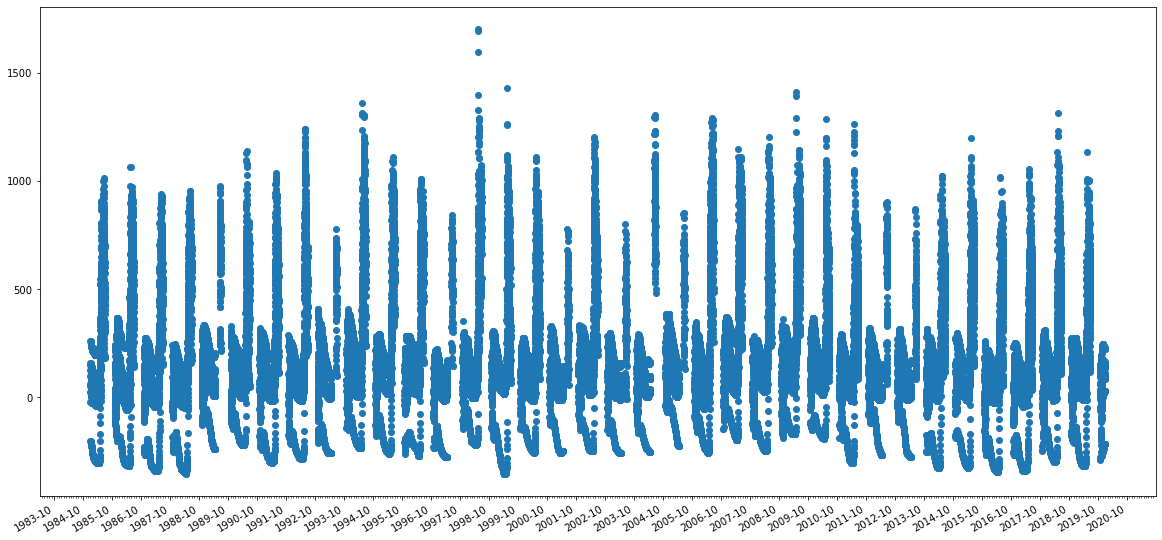

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter('date', 'stage_max', data=X_train)
fmt_half_year = mdates.MonthLocator(interval=12)
ax.xaxis.set_major_locator(fmt_half_year)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.format_xdata = mdates.DateFormatter('%Y-%m')

fig.autofmt_xdate()
plt.show()

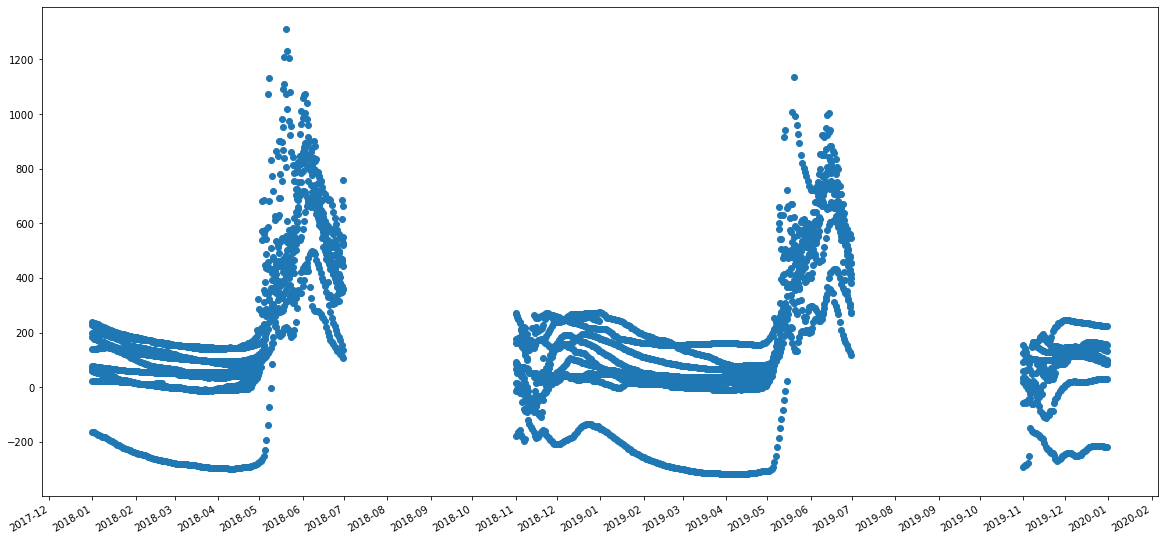

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot('date', 'stage_max', data=X_train[X_train.date >= '2018-01-01'], linestyle='none', marker='o')
fmt_half_year = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_half_year)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.format_xdata = mdates.DateFormatter('%Y-%m')

fig.autofmt_xdate()
plt.show()

In [9]:
# Логика работы c пропусками:
# На текущий момент реализована только одна стратегия:
# На обучении: выбрасываются все наблюдения, для которых невозможно собрать полный набор таргетов и признаков
# На тестировании: выбрасываются все наблюдения, для которых невозможно собрать полный набор признаков.

In [10]:
# трейн датасет
train = X_train[X_train.date < '2018-01-01'].copy().fillna(0)
# тест датасет
# +7 точек пересечения с трейном для подсчета признаков на первую дату теста
test = X_train[X_train.date >= '2017-12-25'].copy().fillna(0)

In [11]:
test

,station_id,date,stage_avg,stage_min,stage_max,temp,ice_thickness,place,discharge,water_code_16,...,h_mean,cnt_river_big,len_river_ m,river_pltn,area_m2,crivisna_5km,crivisna_10km,wind_direction_sin,wind_direction_cos,id
7054,3019,2017-12-25,30.0,30.0,30.0,-1.0,-1.0,3,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.419614,0.907703,3019
7055,3019,2017-12-26,30.0,30.0,30.0,-1.0,-1.0,3,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.840284,0.542146,3019
7056,3019,2017-12-27,28.0,28.0,28.0,-1.0,-1.0,3,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.776903,0.629620,3019
7057,3019,2017-12-28,26.0,26.0,26.0,-1.0,-1.0,3,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.908740,0.417363,3019
7058,3019,2017-12-29,24.0,24.0,24.0,-1.0,-1.0,3,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.704594,0.709611,3019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78785,3230,2018-12-27,251.0,251.0,251.0,-1.0,-1.0,3,-1.0,0,...,1686.000000,84,1.788739e+07,0.000027,6.553039e+11,8540.857101,25406.537157,0.999645,0.026635,3230
78786,3230,2018-12-28,250.0,250.0,250.0,-1.0,-1.0,3,-1.0,0,...,1686.000000,84,1.788739e+07,0.000027,6.553039e+11,8540.857101,25406.537157,0.721655,0.692253,3230
78787,3230,2018-12-29,247.0,247.0,247.0,-1.0,-1.0,3,-1.0,0,...,1686.000000,84,1.788739e+07,0.000027,6.553039e+11,8540.857101,25406.537157,0.528942,0.848658,3230
78788,3230,2018-12-30,244.0,244.0,244.0,-1.0,-1.0,3,-1.0,0,...,1686.000000,84,1.788739e+07,0.000027,6.553039e+11,8540.857101,25406.537157,0.980587,-0.196087,3230


In [12]:
pd.__version__

'1.3.3'

In [16]:
seq_params = {'seq0': {'case': 'next_values', # тип задачи, которую решаем - предсказание следующих значений ряда
                           'params': {'n_target': 7, # число точек, на сколько вперед предсказываем
                                      'history': 7, # размер истории для подсчета признаков
                                      'step': 1, # шаг, через сколько точек взять следующие наблюдение
                                      'from_last': True, # датасет заканчивается на последнем доступном наблюдении 
                                      'test_last': False # предсказывать только последний участок из теста
                                     }},}

roles = {'target': 'stage_max',
         DatetimeRole(seasonality=('d', 'm', 'doy'), base_date=True): 'date',
        'id': ['station_id']}
task = Task('multi:reg', greater_is_better=False, metric='mae', loss='mae')

reader_seq = DictToNumpySeqReader(task=task, cv=2, seq_params=seq_params)
feats_seq = LGBSeqSimpleFeatures(fill_na=True, scaler=True)
model = RandomForestSklearn(default_params={'verbose': 0})
model2 = LinearLBFGS()
model3 = BoostCB()
pipeline_lvl1 = MLPipeline([model], pre_selection=None, features_pipeline=feats_seq, post_selection=None)
pipeline2_lvl1 = MLPipeline([model2], pre_selection=None, features_pipeline=feats_seq, post_selection=None)
pipeline3_lvl1 = MLPipeline([model3], pre_selection=None, features_pipeline=feats_seq, post_selection=None)
automl_seq = AutoML(reader_seq,
                         [[pipeline3_lvl1,
                           pipeline2_lvl1,
                           pipeline_lvl1
                          ]],
                         skip_conn=False,
                         blender=WeightedBlender())

oof_pred_seq = automl_seq.fit_predict({'seq': {'seq0': train}}, roles=roles, verbose=4)
seq_test = automl_seq.predict({'seq': {'seq0': test}})

multi:reg isn`t supported in lgb
[12:38:51] CatBoost supports only MultiRMSE metric and loss for multi:reg task.
[12:38:52] Layer 1 train process start. Time left 9999999999.23 secs
[12:39:01] Start fitting Lvl_0_Pipe_0_Mod_0_CatBoost ...
[12:39:01] Training params: {'task_type': 'CPU', 'thread_count': 4, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
[12:39:01] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_CatBoost =====
[12:39:02] 0:	learn: 628.2915436	test: 619.8612905	best: 619.8612905 (0)	total: 174ms	remaining: 8m 40s
[12:39:11] 100:	learn: 167.0717662	test: 167.9677599	best: 167.

[12:47:55] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LinearL2 =====
[12:47:58] Linear model: C = 1e-05 score = -144.41201909466284
[12:48:01] Linear model: C = 5e-05 score = -106.21123386712198
[12:48:04] Linear model: C = 0.0001 score = -80.56205051850779
[12:48:08] Linear model: C = 0.0005 score = -39.53919591102441
[12:48:11] Linear model: C = 0.001 score = -32.28609626793946
[12:48:14] Linear model: C = 0.005 score = -27.597351005711896
[12:48:18] Linear model: C = 0.01 score = -25.88154550746902
[12:48:21] Linear model: C = 0.05 score = -24.389278149451577
[12:48:25] Linear model: C = 0.1 score = -24.03631011585785
[12:48:28] Linear model: C = 0.5 score = -23.710823301016713
[12:48:32] Linear model: C = 1 score = -23.48670604762227
[12:48:35] Linear model: C = 5 score = -23.31657970337447
[12:48:39] Linear model: C = 10 score = -23.18434797589636
[12:48:42] Linear model: C = 50 score = -23.08068443243401
[12:48:46] Linear model: C = 100 score = -22.99333091830879
[12:

In [ ]:
# Альтернативный способ запуска:
model = AutoTS(task, seq_params=seq_params, trend_params={'trend': False})
oof_pred_seq = model.fit_predict(train, roles=roles, verbose=4)
seq_test = model.predict(test, return_raw=True)

In [17]:
train

,station_id,date,stage_avg,stage_min,stage_max,temp,ice_thickness,place,discharge,water_code_16,...,h_mean,cnt_river_big,len_river_ m,river_pltn,area_m2,crivisna_5km,crivisna_10km,wind_direction_sin,wind_direction_cos,id
0,3019,1985-01-01,-23.0,-23.0,-23.0,-1.0,-1.0,3,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.965892,-0.258947,3019
1,3019,1985-01-02,-23.0,-23.0,-23.0,-1.0,-1.0,3,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.058789,0.998270,3019
2,3019,1985-01-03,-23.0,-23.0,-23.0,-1.0,-1.0,3,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.167435,0.985883,3019
3,3019,1985-01-04,-24.0,-24.0,-24.0,-1.0,-1.0,3,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.000000,1.000000,3019
4,3019,1985-01-05,-24.0,-24.0,-24.0,-1.0,53.0,1,-1.0,1,...,730.406696,20,3.376081e+06,0.000028,1.200374e+11,14968.288658,35485.035967,0.000000,1.000000,3019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78543,3230,2017-12-27,249.0,249.0,249.0,-1.0,-1.0,3,-1.0,0,...,1686.000000,84,1.788739e+07,0.000027,6.553039e+11,8540.857101,25406.537157,0.686106,0.727501,3230
78544,3230,2017-12-28,247.0,247.0,247.0,-1.0,-1.0,3,-1.0,0,...,1686.000000,84,1.788739e+07,0.000027,6.553039e+11,8540.857101,25406.537157,0.693191,0.720754,3230
78545,3230,2017-12-29,246.0,246.0,246.0,-1.0,-1.0,3,-1.0,0,...,1686.000000,84,1.788739e+07,0.000027,6.553039e+11,8540.857101,25406.537157,0.795906,0.605420,3230
78546,3230,2017-12-30,244.0,244.0,244.0,-1.0,-1.0,3,-1.0,0,...,1686.000000,84,1.788739e+07,0.000027,6.553039e+11,8540.857101,25406.537157,0.930892,0.365295,3230


In [18]:
# структура предсказаний
# pred:
# pred[0] - предсказание на первых history теста,
# в нашем случае - с признаков последней недели трейна на первую неделю теста
# pred[-1] - предсказание последних history теста,
# в нашем случае это признаки последних 7 дней тестовых данных на неизветное для нас будущее.

# Так же можно посмотреть базовую дату, от которой делалось предсказание:
# seq_test.date
# Тогда структура выглядит следующим образом:
# БД: БД + 1, БД + 2, ... БД + 7.
# pred[i] = [day1, day2, ..., day7]

seq_test.date[0], seq_test.date[-1]

(numpy.datetime64('2017-12-31T00:00:00.000000000'),
 numpy.datetime64('2018-12-31T00:00:00.000000000'))

In [19]:
seq_test.shape

(4494, 7)

In [20]:
seq_test.date[(seq_test.id == 3230)].shape

(237,)

Day 1: RMSE 16.785425186157227: MAE 7.046176910400391
Day 2: RMSE 27.744632720947266: MAE 11.100811958312988
Day 3: RMSE 34.95347213745117: MAE 13.755001068115234
Day 4: RMSE 38.312801361083984: MAE 15.845697402954102
Day 5: RMSE 40.56074142456055: MAE 17.75502586364746
Day 6: RMSE 43.00950622558594: MAE 19.902925491333008
Day 7: RMSE 45.8995475769043: MAE 21.158937454223633


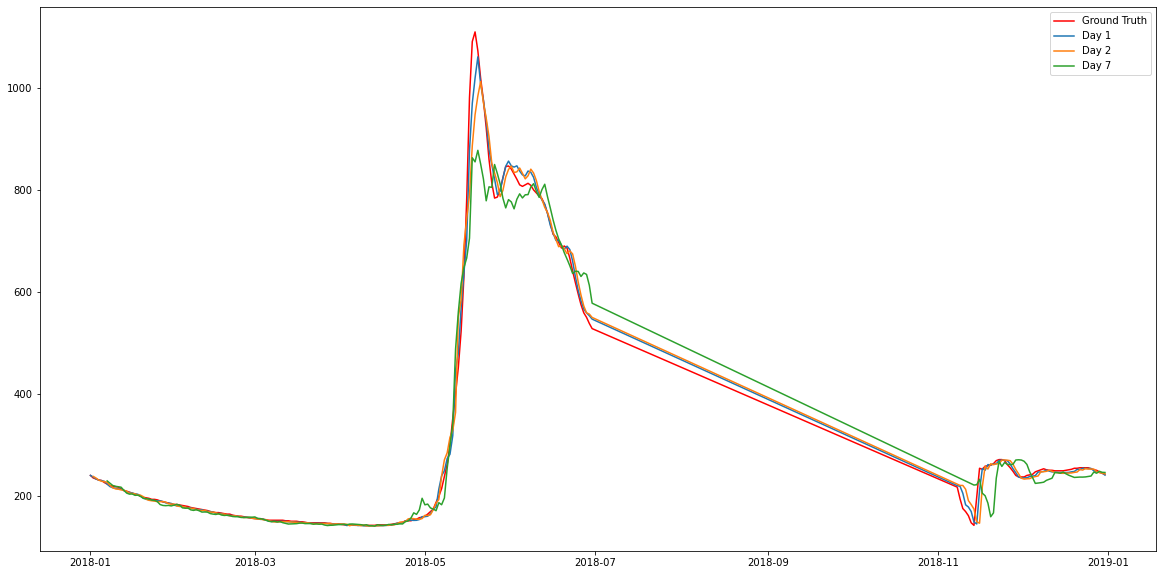

In [21]:
def rmse(x, y): return np.sqrt(mean_squared_error(x, y))


COND_ID = seq_test.id == 3230
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(7):
    res = pd.DataFrame()
    res['date'] = (seq_test.date[:-1] + pd.Timedelta(1+i, unit='D'))[COND_ID[:-1]]
    res['station_id'] = 3230
    res['pred'] = seq_test.data[:-1, i][COND_ID[:-1]]
    df_res = res.merge(test[['station_id', 'date', 'stage_max']], on=['station_id', 'date'], how='left').dropna(axis=0)
    metric = rmse(df_res['stage_max'], df_res['pred'])
    metric2 = mean_absolute_error(df_res['stage_max'], df_res['pred'])

    print(f'Day {i+1}: RMSE {metric}: MAE {metric2}')
    if i == 0:
        ax.plot(df_res['date'], df_res['stage_max'], c='r', label='Ground Truth')
    if i in [0, 1, 6]:
        ax.plot(df_res['date'], df_res['pred'], label=f'Day {i+1}')
plt.legend()
plt.show()
    
    

In [31]:
# Напомним метрики индивидуальной модели:
#Day 1: RMSE 22.6078972608047: MAE 9.314759209815492
#Day 2: RMSE 31.256441757927064: MAE 13.489665346595862
#Day 3: RMSE 36.862186625881094: MAE 16.714155981551002
#Day 4: RMSE 39.84179170236042: MAE 19.29635726728814
#Day 5: RMSE 40.52093461781586: MAE 20.361115980778496
#Day 6: RMSE 41.232630641423704: MAE 21.351129489474825
#Day 7: RMSE 41.8281291397289: MAE 22.24936905249352

In [23]:
def rmse(x, y): return np.sqrt(mean_squared_error(x, y))

for i in range(7):
    res = pd.DataFrame()
    res['date'] = seq_test.date[:-1] + pd.Timedelta(1+i, unit='D')
    res['pred'] = seq_test.data[:-1, i]
    res['station_id'] = seq_test.id[:-1]
    df_res = res.merge(test[['station_id', 'date', 'stage_max']], on=['station_id', 'date'], how='left').dropna(axis=0)
    metric = rmse(df_res['stage_max'], df_res['pred'])
    metric2 = mean_absolute_error(df_res['stage_max'], df_res['pred'])
    print(f'Global, Day {i+1}: RMSE {metric}: MAE {metric2}')



    

Global, Day 1: RMSE 26.30278968811035: MAE 8.719441413879395
Global, Day 2: RMSE 37.71841812133789: MAE 14.066710472106934
Global, Day 3: RMSE 45.09953308105469: MAE 18.355783462524414
Global, Day 4: RMSE 51.51797866821289: MAE 22.14740562438965
Global, Day 5: RMSE 57.62017822265625: MAE 25.615278244018555
Global, Day 6: RMSE 62.88344192504883: MAE 28.66356086730957
Global, Day 7: RMSE 68.19508361816406: MAE 31.446548461914062
